## 1. Introduction

In this notebook we will setup a GAN and train it to learn to generate Monet styled images.

The dataset used for this notebook comes from the Kaggle Competition [I’m Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started).

I will setup a DC-GAN to be specifically. I've used this code earlier for the Kaggle competition to generate Dog images. The code is further modified and optimized to hopefully generate better quality of Monet styles images.

Note that the original code was inspired by the GAN example codes as available on the Keras website and the Machinelearningmastery websites.

## 2. Exploratory Data Analysis




First lets import the required modules for Python.

In [1]:
# Import Modules
import numpy as np
import os
import matplotlib.pyplot as plt
import zipfile
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Reshape, Flatten, Conv2D, UpSampling2D, ReLU, LeakyReLU
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from PIL import Image

Next we set various required constants, the random state seeds for Numpy and Tensorflow and the base directory containing all the images

In [2]:
# Constants and Directories
SEED = 4250
IMAGE_SIZE = 256
random_dim = 256
DROPOUT = 0.05
LEAKY_RELU = 0.05
EPOCHS = 250
BATCH_SIZE = 16

# Set Seed
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Base Dir
IMAGES_DIR = 'C:/Kaggle/gan-getting-started/'

Next we'll define a function to load all required images into a numpy array.

In [3]:
# Load all Training Images
def load_images():
    # Place holder for output 
    all_images = np.zeros((300, IMAGE_SIZE, IMAGE_SIZE, 3))
    
    # File Lists
    IMAGES = os.listdir(f'{IMAGES_DIR}monet_jpg/')

    # Summary
    print(f'Total Images: {len(IMAGES)}\n')

    # Index
    index = 0    
    
    for file_name in IMAGES:
        img = Image.open(f'{IMAGES_DIR}monet_jpg/{file_name}') 
        img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.LANCZOS)
        img = np.asarray(img)
                
        # Normalize to range[-1, 1]
        all_images[index,:] = (img.astype(np.float32) - 127.5)/127.5
        
        index += 1

    return all_images

In [4]:
all_dirs = os.listdir(IMAGES_DIR)
print(all_dirs)

['monet_jpg', 'monet_tfrec', 'photo_jpg', 'photo_tfrec']


In the main directory there are 4 subdirectories. We have 2 directories with plain jpg images and 2 directories with TF Records. In this notebook we will only use plain images and not TF Records.

The 'monet_jpg' directory contains all the jpg files with the Monet paintings. The 'photo_jpg' contains images that could be used to transfer the style of Monet paintings to with a certain GAN. In this notebook we will generate the fake Monet images from scratch.

In [5]:
all_monet_images = os.listdir(f'{IMAGES_DIR}monet_jpg')
print(len(all_monet_images))

300


We have 300 images available for training the GAN model. This is not a very large dataset. We can partially compensate for that by keeping the batch size not to large. Increasing the amount of epochs and shuffling the order of the images for each epoch.

As a final step lets take a look at a few sample images.

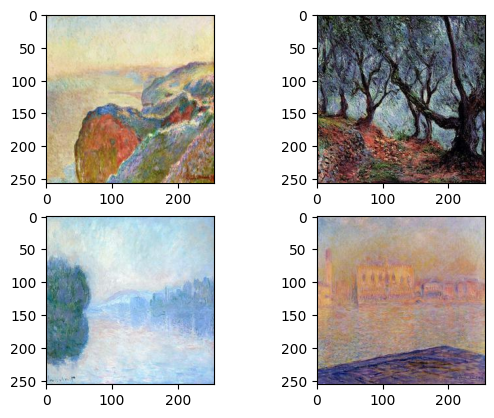

In [6]:
fig, ax = plt.subplots(2,2)
ax[0, 0].imshow(Image.open(f'{IMAGES_DIR}monet_jpg/{all_monet_images[0]}'))
ax[0, 1].imshow(Image.open(f'{IMAGES_DIR}monet_jpg/{all_monet_images[1]}'))
ax[1, 0].imshow(Image.open(f'{IMAGES_DIR}monet_jpg/{all_monet_images[2]}'))
ax[1, 1].imshow(Image.open(f'{IMAGES_DIR}monet_jpg/{all_monet_images[3]}'))
plt.show()
plt.close()

## 3. Model and Training



## 3.1 Model Setup

As a first step we will define the Generator part. This model contains multiple upsampling blocks to eventually generate an image output of 256 * 256 pixels.

In [7]:
def create_generator():
    # Random Normal Weight Initialization
    init = RandomNormal(mean = 0.0, stddev = 0.025)

    # Model
    model = Sequential()

    # Start at 4 * 4
    start_shape = 128 * 4 * 4
    model.add(Dense(start_shape, kernel_initializer = init, input_dim = random_dim))
    model.add(Reshape((4, 4, 128)))
    
    # Loop to create all UpSample Blocks
    for X in [8, 16, 32, 64, 128, 256]: # Upsample sizes for each block
        # Upsample ==> X * X 
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size = 4, padding = "same", kernel_initializer = init))
        model.add(ReLU())
            
    # output
    model.add(Conv2D(3, kernel_size = 4, activation = 'tanh', padding = 'same', kernel_initializer = init))
    model.compile(loss = 'binary_crossentropy', 
                  optimizer = Adam(learning_rate = 0.0001, beta_1 = 0.5))

    # Summary
    print('\n===== GENERATOR SUMMARY ======================================\n')
    print(model.summary())

    return model

Next we define the Discriminator. It contains multiple downsampling blocks and eventually a Dense layer to classify between the real and fake images.

In [8]:
def create_discriminator():
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

    # Random Normal Weight Initialization
    init = RandomNormal(mean = 0.0, stddev = 0.025)

    # Define Model
    model = Sequential()

    # Input Layer
    model.add(Input(shape = input_shape))
    
    # Loop to create all DownSample Blocks
    for X in [128, 64, 32, 16, 8, 4]: # Downsample sizes for each block
        # Downsample ==> X * X
        model.add(Conv2D(128, kernel_size = 4, strides = 2, padding = 'same', kernel_initializer = init))
        model.add(LeakyReLU(LEAKY_RELU))
        model.add(Dropout(DROPOUT))
        
    # Final Layers
    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = init))

    # Compile model
    model.compile(loss = 'binary_crossentropy', 
                  optimizer = Adam(learning_rate = 0.0001, beta_1 = 0.5))
    
    # Summary
    print('\n===== DISCRIMINATOR SUMMARY ======================================\n')
    print(model.summary())
    
    return model

Finally we combine the Generator and Discriminator into the DC-GAN model.

In [9]:
# Combine and Create DC-GAN
def create_dcgan(discriminator, generator, random_dim):
    # Set Discriminator to Not Trainable
    discriminator.trainable = False
    
    # Gan Input
    gan_input = Input(shape = (random_dim,))
    
    # Generator Output...an image
    generator_output = generator(gan_input)
    
    # Combine and Create DC-GAN
    gan_output = discriminator(generator_output)
    model = Model(inputs = gan_input, outputs = gan_output)
    model.compile(loss = 'binary_crossentropy', 
                  optimizer = Adam(learning_rate = 0.0001, beta_1 = 0.5))
    
    # Summary
    print('\n===== DC-GAN SUMMARY ======================================\n')
    print(model.summary())
    
    return model

Next some support functions used for plotting and random input for the generator to generate the sample images.

In [10]:
# Function for random input
def generator_input(latent_space_dim, number_of_samples):
    # Generate points
    input = np.random.randn(latent_space_dim * number_of_samples)

    # Reshape to correct input shape
    input = input.reshape((number_of_samples, latent_space_dim))

    return input
    
# Function to plot generated sample images.
def plot_generated_images(generator, examples = 16, dim = (4, 4)):
    generated_images = generator.predict(np.random.normal(0, 1, size = [examples, random_dim]), verbose = 0)
    generated_images = ((generated_images + 1) * 127.5).astype('uint8')
        
    plt.figure(figsize = (18, 12))
    plt.title('Generated Sample Paintings')
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation = 'nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()

# Function to plot the Loss Metrics
def plot_loss(d_f, d_r, g):
    plt.figure(figsize = (18, 12))
    plt.title('Training Loss Plot')
    plt.plot(d_f, label = 'Discriminator Fake Loss')
    plt.plot(d_r, label = 'Discriminator Real Loss')
    plt.plot(g, label = 'Generator Loss')
    plt.legend()
    plt.show()
    plt.close()

Next the final function to train the model for X number of epochs.

In [11]:
def train_model(epochs = 1, batch_size = 16):
    # Load images
    x_train = load_images()
    
    # Number of batches
    batch_count = x_train.shape[0] // batch_size

    # Create Generator and Discriminator Models
    generator = create_generator()
    discriminator = create_discriminator()
    
    # Create GAN Model
    gan_model = create_dcgan(discriminator, generator, random_dim)
    
    # Lists for Loss History
    discriminator_fake_hist, discriminator_real_hist, generator_hist = [], [], []
    
    for e in tqdm(range(epochs), total = epochs):

        # Random Shuffle each epoch
        np.random.shuffle(x_train)
        
        # Batch Loop
        for _ in range(batch_count):
            
            # Discriminator Loss
            discriminator_fake_loss, discriminator_real_loss = [], []
            
            # Train the Discriminator more than the Generator
            for _ in range(2):
                # Train discriminator on Fake Images
                X_fake = generator.predict(generator_input(random_dim, batch_size), verbose = 0)
                y_fake = np.zeros(batch_size)
                y_fake[:] = 0
                discriminator.trainable = True
                d_fake_loss = discriminator.fit(X_fake, y_fake, batch_size = batch_size, verbose = 0)
                
                # Train discriminator on Real Images
                X_real = x_train[np.random.randint(0, x_train.shape[0], size = batch_size)]
                y_real = np.zeros(batch_size)
                y_real[:] = 0.95  # label smoothing
                discriminator.trainable = True
                d_real_loss = discriminator.fit(X_real, y_real, batch_size = batch_size, verbose = 0)

                # Store Loss each iteration
                discriminator_fake_loss.append(d_fake_loss.history['loss'])
                discriminator_real_loss.append(d_real_loss.history['loss'])

            # Train generator
            noise = generator_input(random_dim, batch_size)
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            generator_loss = gan_model.fit(noise, y_gen, batch_size = batch_size, verbose = 0)

            # Store Loss in Loss History lists
            discriminator_fake_hist.append(np.mean(discriminator_fake_loss))
            discriminator_real_hist.append(np.mean(discriminator_real_loss)) 
            generator_hist.append(generator_loss.history['loss'])
                    
    # Print Sample Images
    plot_generated_images(generator)
                    
    # Plot Loss during Training
    plot_loss(discriminator_fake_hist, discriminator_real_hist, generator_hist)
    
    return generator

## 3.2 Model Training

Finally we can start the DC GAN model training. The model will be trained for 250 epochs with a batch size of 16 images.

After the training is completed some generated sample images will be plotted and the training loss for the generator and discriminator

Total Images: 300


===== GENERATOR SUMMARY ======================================

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              526336    
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 128)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 128)         262272    
                                                                 
 re_lu (ReLU)                (None, 8, 8, 128)         0         
                                                                 
 up_sampling2d_1 (UpSampling  (None, 1

100%|██████████| 250/250 [1:05:43<00:00, 15.77s/it]
C:\Users\robin\AppData\Local\Temp\ipykernel_23156\151931983.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(dim[0], dim[1], i + 1)


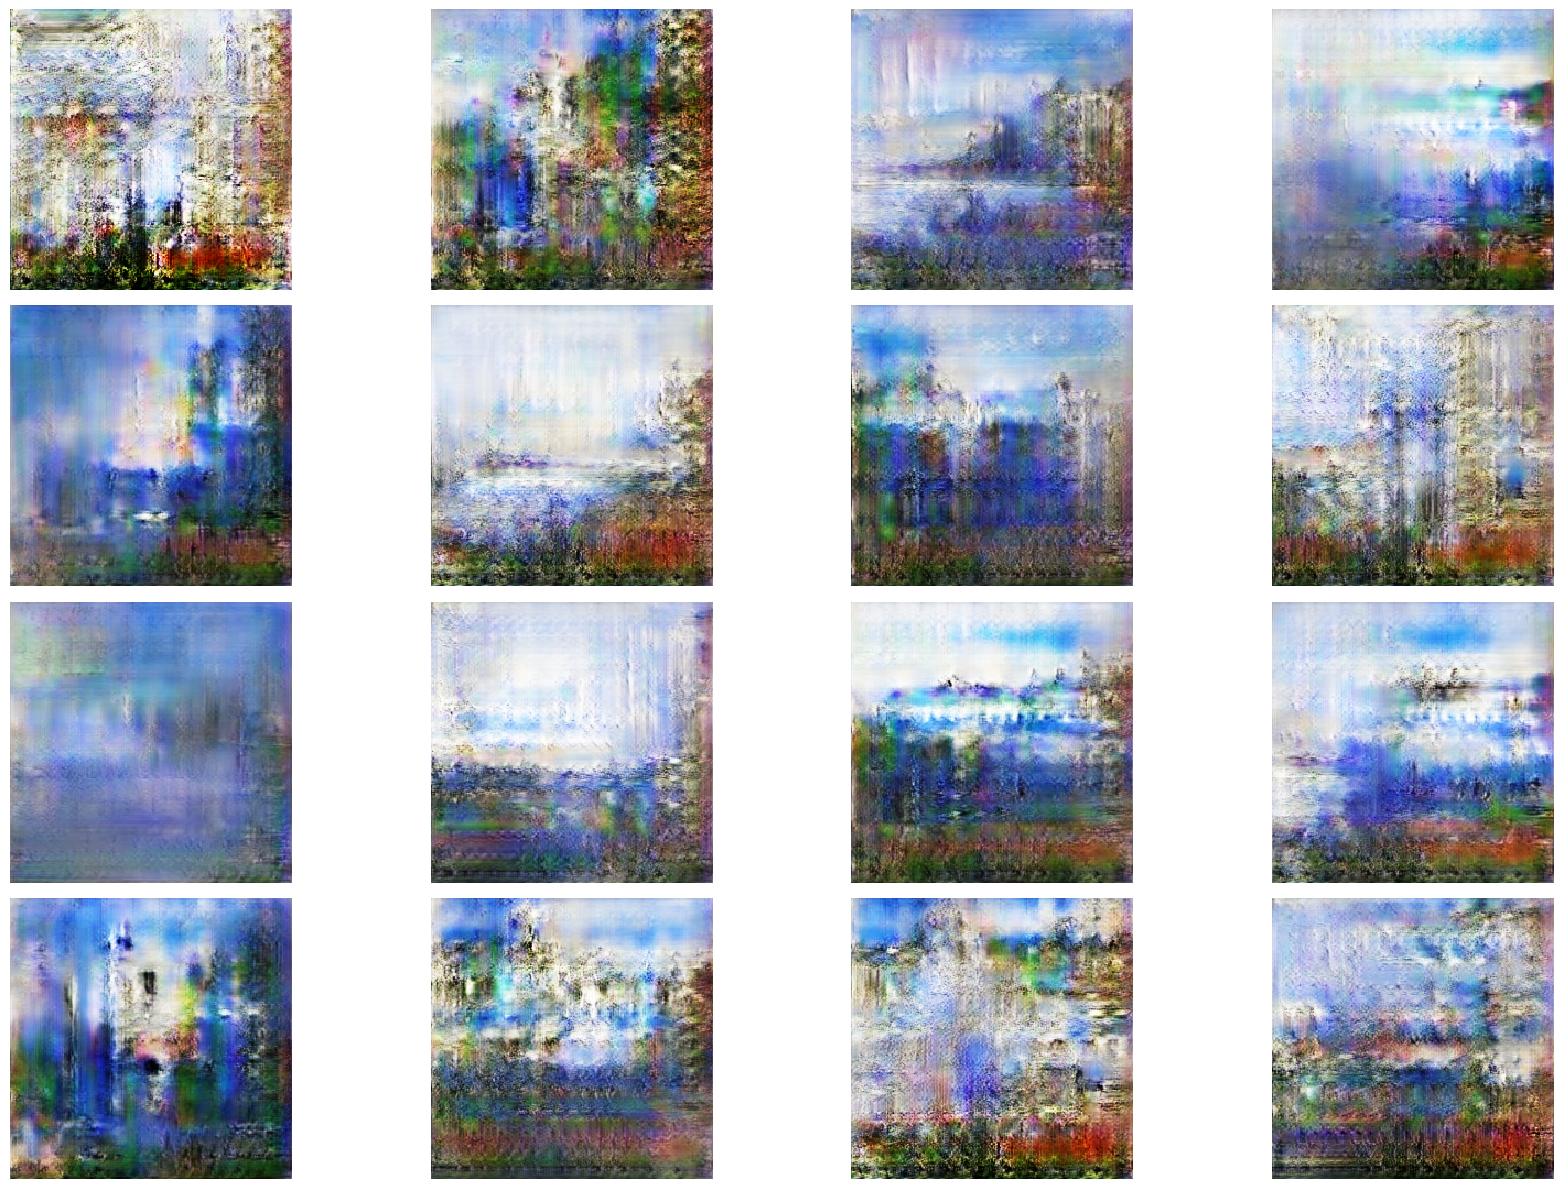

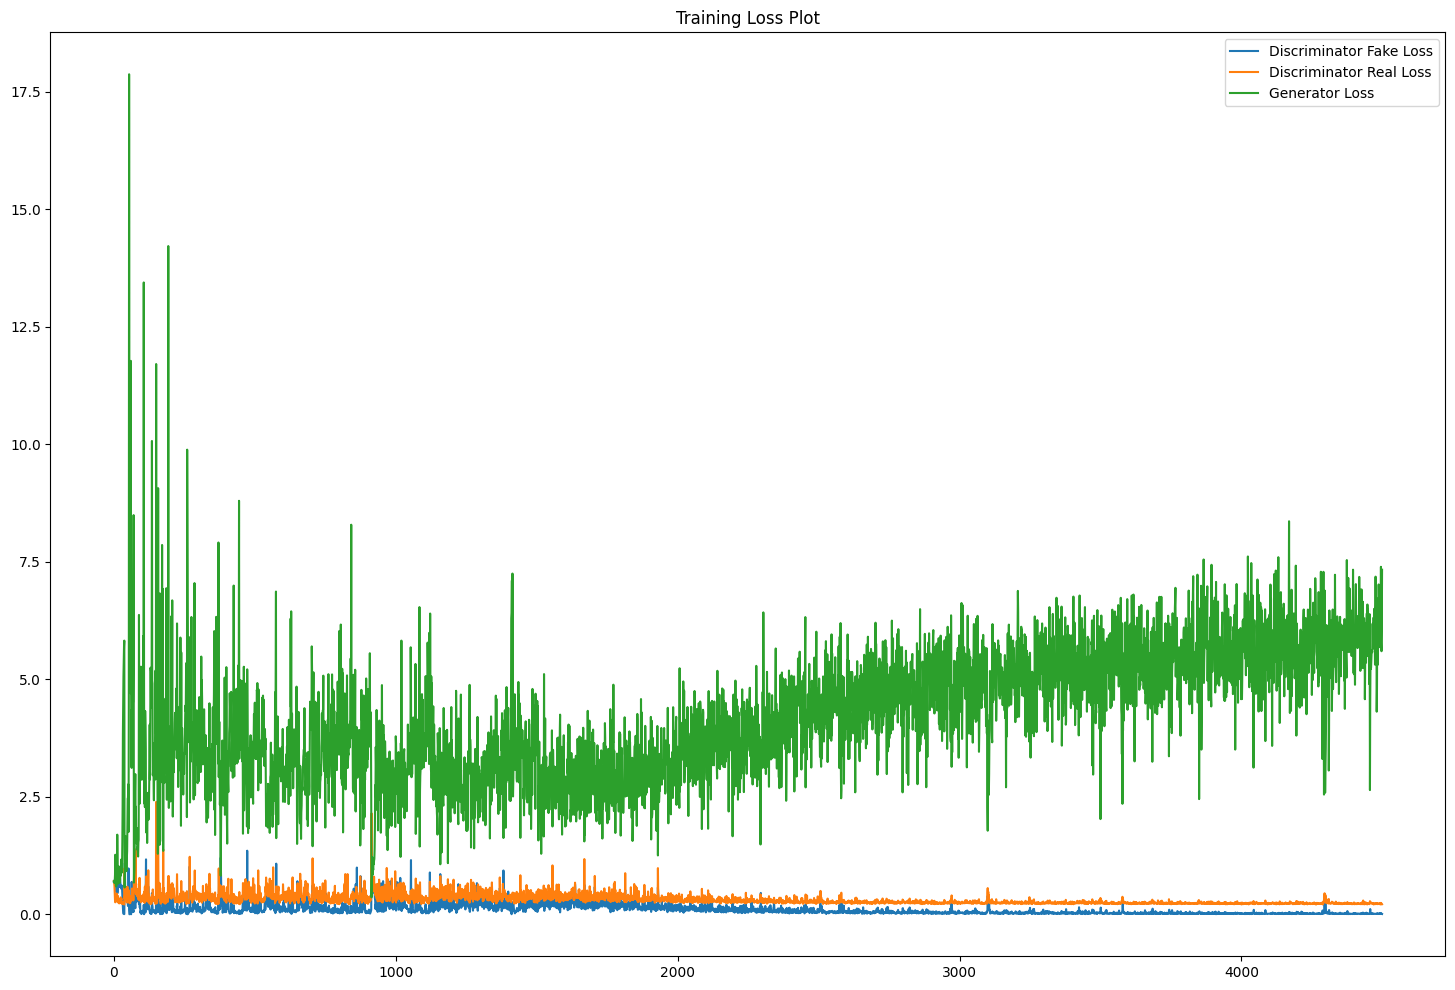

In [12]:
generator = train_model(EPOCHS, BATCH_SIZE)

## 3.3 Create Submission File

To create a submission file for the Kaggle Competition we must create a file called 'images.zip' through a Kaggle Notebook. The zip file must contain between 7000 and 10000 generated images with a size of 256 * 256 pixels.

The Monet images can be generated or a GAN can be used to transfer the Monet style to the 7038 images that are present in the folder 'photo_jpg'. With the code below they are generated based on the randomized input.

In [13]:
# Create Images.zip
zip_file = zipfile.PyZipFile('images.zip', mode = 'w')
total_files = 7100

# Loop
for i in tqdm(range(total_files), total = total_files):
    # Generate Monet painting
    generated_images = generator.predict(np.random.normal(0, 1, size = [1, random_dim]), verbose = 0)
    image = Image.fromarray(((generated_images + 1) * 127.5).astype('uint8').reshape(IMAGE_SIZE, IMAGE_SIZE, 3))

    # Save to zip file  
    jpg_file_name = f'{i}.jpg'
    image.save(jpg_file_name, 'jpEg')
    zip_file.write(jpg_file_name)
    os.remove(jpg_file_name)

# Close Handle
zip_file.close()

100%|██████████| 7100/7100 [06:47<00:00, 17.43it/s]


## 4. Results

The submission from this DC-GAN notebook reached a score of about 114 on the Kaggle competition leaderboard. I did some experiments with more epochs but this leads to a higher score (which means a worse result..) on the leaderboard. 

Also increasing the Dropout actually decreases the performance of the model.

There are many scenario's that could be tuned for this model. The problem is however that there is no way to perform a good local validation of the model. Observing the generated sample output images gives however a good but subjective impression of the achieved results.

## 5. Conclusion

In this notebook we experimented with using a DC-GAN to create Monet styled paintings. While the DC-GAN is certainly not the best performing GAN any more - especially not when compared to current Generative AI models like DALL-E or Stable Diffusion 2 - it has a really simple to implement model structure + code. Combined with a short time to train the model on the input dataset it allows for easy and quick experimentation with various hyper parameters.

It is an ideal framework to build up some basic knowledge about generative AI models while achieving simple but nice results.